In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from glob import glob
from datetime import datetime
import seaborn as sns
from pandas.plotting import autocorrelation_plot
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error
import scipy.stats as st

sns.set()



/Users/immanuel4n/anaconda3/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [53]:
solar_sales = pd.read_excel('sunsales_2014_2018.xlsx', sheet_name='Sheet1')

#### CLEANING UP THE DATA

In [78]:
# CHOOSING RELEVANT COLUMNS

solsales = solar_sales.loc[:,['End Customer', 'Product Hierarchy', 'Product Family',
       'Geographic Region', 'Sold-to party', 'Distributor', 'Part Number',
       'Quarter of Year', 'Month of Year', 'Net Inv Qty', 'Net Inv-$']]


# REFORMATING COLUMNS AND INSERTING NEW COLUMNS

solsales.insert(loc=8, column='Month2', value = solsales['Month of Year'].str[7:].str.replace(' ','-'))

# REFORMATING COLUMNS AND INSERTING NEW COLUMNS

solsales.insert(loc=8, column='Quarter', value = 'Q'+ solsales['Quarter of Year'].astype(str).str[4])

# REFORMATING COLUMNS,INSERTING NEW COLUMNS AND DROPPING OTHERS

solsales.insert(loc=8, column='Month', value = solsales['Month2'])
solsales.drop(['Quarter of Year','Month of Year', 'month', 'Month2'], axis=1, errors='ignore', inplace = True)


# Transforming month into datetime format
solsales['Month'] = pd.to_datetime(solsales['Month'], format='%m-%Y')


# REFORMATING COLUMNS,INSERTING MONTH AND YEAR

solsales.insert(loc=8, column='Year', value = solsales['Month'].dt.year)
solsales.insert(loc=8, column='Month2', value = solsales['Month'].dt.month)

solsales.drop(['Month'], axis=1, errors='ignore', inplace = True)

solsales.rename(columns={'Month2': 'Month'}, inplace= True)

solsales['Net Inv Qty'].value_counts(dropna = False).head(2)

#### ** FROM THE RESULT ABOVE IT INDICATES THERE ARE 3424 NAN VALUES IN THE QTY COLUMN **

In [85]:
solsales[solsales['Net Inv Qty'].isnull()].head(3)

End Customer Product Hierarchy Product Family  \
0       *SANMINA/ARROW YRLY 2013     PPF650NA09 ZZ    Midgit KLKD   
2     *PLATT VARIOUS CONTRACTORS     PPF650NA09 ZZ    Midgit KLKD   
3  *ARCELOR MITTAL DOFASCO STEEL     PPF650NA09 ZZ    Midgit KLKD   

  Geographic Region  Sold-to party                      Distributor  \
0            US/CAN         306110                ARROW PEMCO GROUP   
2            US/CAN         406311  PLATT ELECTRIC SUPPLY-ROSEVILLE   
3            US/CAN         323645           NATIONAL FUSE PRODUCTS   

  Part Number  Month  Year Quarter  Net Inv Qty  Net Inv-$  
0   KLKD030.T      1  2014      Q1          NaN  -25086.51  
2   KLKD015.T      1  2014      Q1          NaN     -18.90  
3   KLKD.500T      1  2014      Q1          NaN     -97.20

** The NaN value fields all have corresponding negative sales dollars. This is due to ship and debit process with Distributors. We can safely delete all records with these NaN values as they are not relevant to our analysis **

In [86]:

# Checking that all the NaN records have been dropped.
slr_sls = solsales.dropna()

slr_sls.info()

slr_sls['Net Inv Qty'].value_counts(dropna = False).head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 26152 entries, 1 to 29915
Data columns (total 12 columns):
End Customer         26152 non-null object
Product Hierarchy    26152 non-null object
Product Family       26152 non-null object
Geographic Region    26152 non-null object
Sold-to party        26152 non-null int64
Distributor          26152 non-null object
Part Number          26152 non-null object
Month                26152 non-null int64
Year                 26152 non-null int64
Quarter              26152 non-null object
Net Inv Qty          26152 non-null float64
Net Inv-$            26152 non-null float64
dtypes: float64(2), int64(3), object(7)
memory usage: 2.6+ MB


10.0     5342
20.0     2377
100.0    2101
30.0     1163
50.0     1134
Name: Net Inv Qty, dtype: int64

#### Visual Analysis

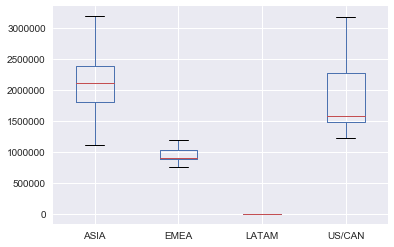

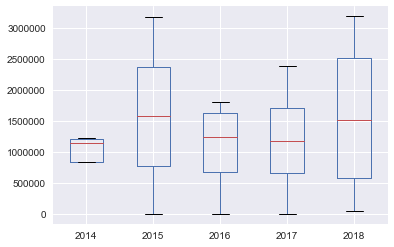

Net Inv Qty                                                        
Year           2014          2015          2016          2017          2018
count  4.000000e+00  4.000000e+00  4.000000e+00  4.000000e+00  4.000000e+00
mean   8.824770e+05  1.582397e+06  1.070201e+06  1.188924e+06  1.566689e+06
std    5.887321e+05  1.369326e+06  8.072041e+05  1.002952e+06  1.426316e+06
min    2.512000e+03  2.460000e+03  3.296000e+03  6.870000e+03  4.747500e+04
25%    8.312208e+05  7.788308e+05  6.765260e+05  6.623700e+05  5.764935e+05
50%    1.152010e+06  1.573098e+06  1.240136e+06  1.179558e+06  1.516326e+06
75%    1.203266e+06  2.376664e+06  1.633811e+06  1.706111e+06  2.506521e+06
max    1.223376e+06  3.180932e+06  1.797236e+06  2.389709e+06  3.186628e+06

In [173]:
# Checking for any outliers
slr_sls_rnge = slr_sls.loc[:,['Geographic Region','Year', 'Net Inv Qty']].groupby(['Geographic Region','Year']).sum()
slr_sls_rgn=slr_sls_rnge.unstack('Geographic Region')
slr_sls_yrly = slr_sls_rnge.unstack()
slr_sls_rgn.plot(y='Net Inv Qty',kind = 'box'); plt.show()
slr_sls_yrly.plot(y='Net Inv Qty',kind = 'box'); plt.show()

slr_sls_yrly.describe()

In [88]:
# Checking for any duplicates
slrsls_noduplicates = slr_sls.drop_duplicates()
slrsls=slrsls_noduplicates
slrsls_noduplicates.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 25465 entries, 1 to 29915
Data columns (total 12 columns):
End Customer         25465 non-null object
Product Hierarchy    25465 non-null object
Product Family       25465 non-null object
Geographic Region    25465 non-null object
Sold-to party        25465 non-null int64
Distributor          25465 non-null object
Part Number          25465 non-null object
Month                25465 non-null int64
Year                 25465 non-null int64
Quarter              25465 non-null object
Net Inv Qty          25465 non-null float64
Net Inv-$            25465 non-null float64
dtypes: float64(2), int64(3), object(7)
memory usage: 2.5+ MB


In [89]:
# Introducing average selling price (ASP) per SKU
slrsls['ASP-$']=slrsls['Net Inv-$']/slrsls['Net Inv Qty']


/Users/immanuel4n/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [90]:
slrsls.head(3)

End Customer Product Hierarchy Product Family Geographic Region  \
1  SUN-WA TECHNOS(DAIHEN)     PPF650NA09 ZZ    Midgit KLKD              ASIA   
4   SOLAR SPECIALTY HOUSE     PPF650NA09 ZZ    Midgit KLKD            US/CAN   
5                   DELTA     PPF650NA11 ZZ     Midgit SPF              ASIA   

   Sold-to party              Distributor  Part Number  Month  Year Quarter  \
1         405253          FUJIX CO., LTD.    KLKD005.T      1  2014      Q1   
4         307414            CED-RIVERSIDE    KLKD001.T      1  2014      Q1   
5         403170  LONGVIEW TECHNOLOGY INC  0SPF002.HXR      1  2014      Q1   

   Net Inv Qty  Net Inv-$    ASP-$  
1        200.0     558.93  2.79465  
4        200.0     400.00  2.00000  
5        100.0     328.00  3.28000

In [91]:
slrsls['Geographic Region'].unique()

array(['ASIA', 'US/CAN', 'LATAM', 'EMEA'], dtype=object)

In [92]:
solar_sales.head(3)

Quote                End Customer Product Hierarchy Product Family  \
0   D05013    *SANMINA/ARROW YRLY 2013     PPF650NA09 ZZ    Midgit KLKD   
1  JPIS012      SUN-WA TECHNOS(DAIHEN)     PPF650NA09 ZZ    Midgit KLKD   
2   P30898  *PLATT VARIOUS CONTRACTORS     PPF650NA09 ZZ    Midgit KLKD   

  Geographic Region  Sold-to party                      Distributor  \
0            US/CAN         306110                ARROW PEMCO GROUP   
1              ASIA         405253                  FUJIX CO., LTD.   
2            US/CAN         406311  PLATT ELECTRIC SUPPLY-ROSEVILLE   

  Part Number   Month of Year  Quarter of Year                  Day  \
0   KLKD030.T  Period 01 2014            20141  2014-01-01 00:00:00   
1   KLKD005.T  Period 01 2014            20141  2014-01-01 00:00:00   
2   KLKD015.T  Period 01 2014            20141  2014-01-01 00:00:00   

   Net Inv Qty  Net Inv-$  
0          NaN  -25086.51  
1        200.0     558.93  
2          NaN     -18.90

In [93]:
ss_monthly = solar_sales.loc[:,['End Customer', 'Product Family',
       'Geographic Region', 'Distributor', 'Part Number',
       'Quarter of Year', 'Month of Year', 'Net Inv Qty', 'Net Inv-$']]

ss_monthly.insert(loc=6, column='Month2', value = ss_monthly['Month of Year'].str[7:].str.replace(' ','-'))
ss_monthly['Month'] = pd.to_datetime(ss_monthly['Month2'], format='%m-%Y')
ss_monthly.insert(loc=6, column='Quarter', value = 'Q'+ ss_monthly['Quarter of Year'].astype(str).str[4])
ss_monthly.drop(['Quarter of Year','Month of Year', 'Month2'], axis=1, errors='ignore', inplace = True)
ss_monthly.rename(columns={'Month': 'Date'}, inplace= True)
ss_monthly = ss_monthly.dropna()

In [94]:
ss_monthly.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 26152 entries, 1 to 29915
Data columns (total 9 columns):
End Customer         26152 non-null object
Product Family       26152 non-null object
Geographic Region    26152 non-null object
Distributor          26152 non-null object
Part Number          26152 non-null object
Quarter              26152 non-null object
Net Inv Qty          26152 non-null float64
Net Inv-$            26152 non-null float64
Date                 26152 non-null datetime64[ns]
dtypes: datetime64[ns](1), float64(2), object(6)
memory usage: 2.0+ MB


In [95]:
ss_sls = ss_monthly.set_index('Date').sort_index()

ss_sls['2014-01':'2014-12'].head(2)


In [97]:
ss_sls['2014Q1'].tail(3)

End Customer Product Family Geographic Region  \
Date                                                                            
2014-03-01    FUSECO POWER SOLUTIONS PTY LTD    Midgit KLKD              ASIA   
2014-03-01  MAYER ELECTRIC-EAST-NORCROSS HUB    Midgit KLKD            US/CAN   
2014-03-01                   FUJIX CO., LTD.    Midgit KLKD              ASIA   

                                 Distributor Part Number Quarter  Net Inv Qty  \
Date                                                                            
2014-03-01    FUSECO POWER SOLUTIONS PTY LTD   KLKD015.T      Q1         40.0   
2014-03-01  MAYER ELECTRIC-EAST-NORCROSS HUB   KLKD006.T      Q1        120.0   
2014-03-01                   FUJIX CO., LTD.   KLKD002.T      Q1         20.0   

            Net Inv-$  
Date                   
2014-03-01      82.00  
2014-03-01     729.00  
2014-03-01     205.89

### 1. Can you count something interesting

In [98]:
# Counting the total number of SKUs and determining the most sold SKU by year.

print('There are',len(ss_sls['Part Number'].unique()), 'part numbers sold')


# Determine the highest sold SKU per year

print('\n************************************* Most sold SKU by year *****************************************\n')


pnum_high = slr_sls.pivot_table(index='Year', columns='Part Number', values='Net Inv Qty', aggfunc='sum')
pnum_dollars = slr_sls.pivot_table(index='Year', columns='Part Number', values='Net Inv-$', aggfunc='sum')

# Function to select the highest selling SKU

def highestsold(dframe):
    part_num = []
    for i in dframe.index:
        temp_dict = {}
        maxval = 0
        for j in dframe.columns:
                if dframe[j][i] > maxval:
                    maxval = dframe[j][i]
                    temp_dict[i] = (j, maxval)
        part_num.append(temp_dict)
    return part_num


pnum=highestsold(pnum_high)
pnumdols=highestsold(pnum_dollars)
            
for u in pnum:
    for i, j in u.items():
        a, b = j
        print('In ',i, 'the highest selling part number was',a,'and it sold',b,'units')


    
print('\n************************************* Highest grossing SKU by year *****************************************\n')

    
for u in pnumdols:
    for i, j in u.items():
        a, b = j
        print('In ',i, 'the highest grossing part number was',a,'and it sold $',round(b,2))   
    

There are 318 part numbers sold

************************************* Most sold SKU by year *****************************************

In  2014 the highest selling part number was 0SPF015.T and it sold 721113.0 units
In  2015 the highest selling part number was 0SPF015.T and it sold 988279.0 units
In  2016 the highest selling part number was 0SPF015.T and it sold 915765.0 units
In  2017 the highest selling part number was 0SPF015.T and it sold 912861.0 units
In  2018 the highest selling part number was 0SPF015.T and it sold 1016961.0 units

************************************* Highest grossing SKU by year *****************************************

In  2014 the highest grossing part number was KLKD030.T and it sold $ 1129823.29
In  2015 the highest grossing part number was SPXI004.L and it sold $ 2019981.4
In  2016 the highest grossing part number was KLKD030.T and it sold $ 873808.32
In  2017 the highest grossing part number was KLKD030.T and it sold $ 873379.94
In  2018 the highest 

#### 2. Can you find trends (e.g. high, low, increasing, decreasing, anomalies)?

**SKU Analysis and Trends:**

Though the same part number sold the highest number of units for all five years, it did not feature as the top grossing part number in any of the five years implying its price is relatively lower than the top grossing part numbers

**Regional Trends From the bar plot below**

Overall 2015 was one of the best years for all the regions while 2016 was a tough year for 
North America and Asia. The latter haven been the strongest markets while EMEA has seen a steady decline since 2015. The Asia market has been growing steadily and is on track to be about par with the NA market.

#### 3. Can you make a bar plot or a histogram?



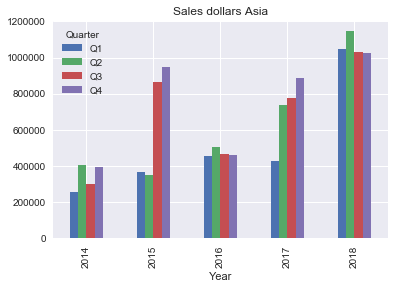

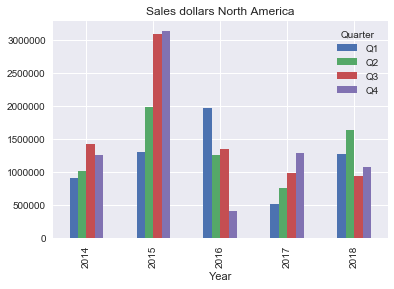

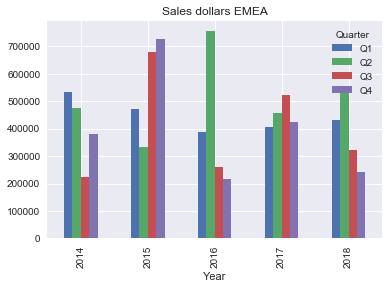

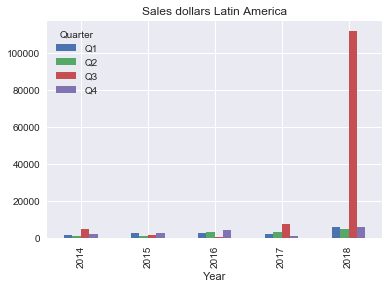

In [99]:
# VISUALIZING THE TOTAL SALES $$ BY QUARTER BY REGION

# plt.subplot(2,2,1)
slrsls_asia = slr_sls[slr_sls['Geographic Region']== 'ASIA'].groupby(['Year','Quarter'])['Net Inv Qty', 'Net Inv-$'].agg({'Net Inv Qty':'sum', 'Net Inv-$':'sum'}).head(20)
slrsls_asia['Net Inv-$'].unstack().plot(kind='bar', title = 'Sales dollars Asia')
plt.show()

# plt.subplot(2,2,2)
slrsls_NA = slrsls[slrsls['Geographic Region']== 'US/CAN'].groupby(['Year','Quarter'])['Net Inv Qty', 'Net Inv-$'].agg({'Net Inv Qty':'sum', 'Net Inv-$':'sum'}).head(20)
slrsls_NA['Net Inv-$'].unstack().plot(kind='bar',title = 'Sales dollars North America')
plt.show()

# plt.subplot(2,2,3)
slrsls_NA = slrsls[slrsls['Geographic Region']== 'EMEA'].groupby(['Year','Quarter'])['Net Inv Qty', 'Net Inv-$'].agg({'Net Inv Qty':'sum', 'Net Inv-$':'sum'}).head(20)
slrsls_NA['Net Inv-$'].unstack().plot(kind='bar',title = 'Sales dollars EMEA')
plt.show()

# plt.subplot(2,2,4)
slrsls_NA = slrsls[slrsls['Geographic Region']== 'LATAM'].groupby(['Year','Quarter'])['Net Inv Qty', 'Net Inv-$'].agg({'Net Inv Qty':'sum', 'Net Inv-$':'sum'}).head(20)
slrsls_NA['Net Inv-$'].unstack().plot(kind='bar',title = 'Sales dollars Latin America')
plt.show()

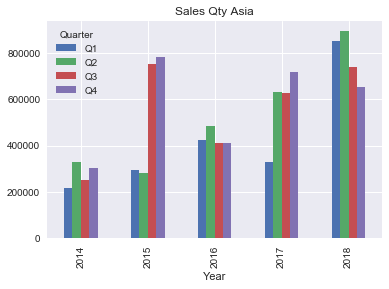

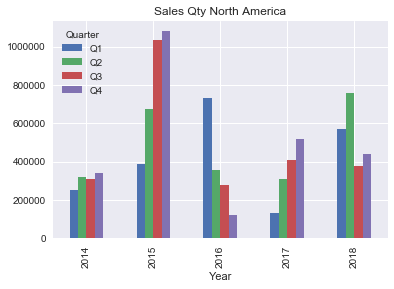

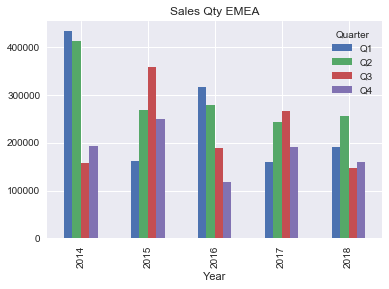

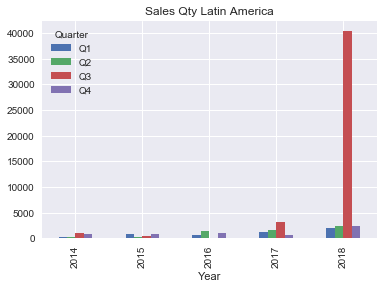

In [100]:
# VISUALIZING THE TOTAL NUMBER OF SKUs SOLD BY QUARTER BY REGION

# plt.subplot(2,2,1)
slrsls_asia = slrsls[slrsls['Geographic Region']== 'ASIA'].groupby(['Year','Quarter'])['Net Inv Qty', 'Net Inv-$'].agg({'Net Inv Qty':'sum', 'Net Inv-$':'sum'}).head(20)
slrsls_asia['Net Inv Qty'].unstack().plot(kind='bar', title = 'Sales Qty Asia')
plt.show()

# plt.subplot(2,2,2)
slrsls_NA = slrsls[slrsls['Geographic Region']== 'US/CAN'].groupby(['Year','Quarter'])['Net Inv Qty', 'Net Inv-$'].agg({'Net Inv Qty':'sum', 'Net Inv-$':'sum'}).head(20)
slrsls_NA['Net Inv Qty'].unstack().plot(kind='bar',title = 'Sales Qty North America')
plt.show()

# plt.subplot(2,2,3)
slrsls_NA = slrsls[slrsls['Geographic Region']== 'EMEA'].groupby(['Year','Quarter'])['Net Inv Qty', 'Net Inv-$'].agg({'Net Inv Qty':'sum', 'Net Inv-$':'sum'}).head(20)
slrsls_NA['Net Inv Qty'].unstack().plot(kind='bar',title = 'Sales Qty EMEA', legend = 'top')
plt.show()

# plt.subplot(2,2,4)
slrsls_NA = slrsls[slrsls['Geographic Region']== 'LATAM'].groupby(['Year','Quarter'])['Net Inv Qty', 'Net Inv-$'].agg({'Net Inv Qty':'sum', 'Net Inv-$':'sum'}).head(20)
slrsls_NA['Net Inv Qty'].unstack().plot(kind='bar',title = 'Sales Qty Latin America')
plt.show()

#### 4. Can you compare two related quantities?

Comparing the average selling price by Product Family over 5 years.

In [101]:
# Determine if there are any columns with zeros Qty or zero dollars.
slrsls.info()
slrsls[(slrsls[['Net Inv Qty','Net Inv-$']]==0).any(axis=1)].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 25465 entries, 1 to 29915
Data columns (total 13 columns):
End Customer         25465 non-null object
Product Hierarchy    25465 non-null object
Product Family       25465 non-null object
Geographic Region    25465 non-null object
Sold-to party        25465 non-null int64
Distributor          25465 non-null object
Part Number          25465 non-null object
Month                25465 non-null int64
Year                 25465 non-null int64
Quarter              25465 non-null object
Net Inv Qty          25465 non-null float64
Net Inv-$            25465 non-null float64
ASP-$                25465 non-null float64
dtypes: float64(3), int64(3), object(7)
memory usage: 2.7+ MB
<class 'pandas.core.frame.DataFrame'>
Int64Index: 1721 entries, 6 to 29898
Data columns (total 13 columns):
End Customer         1721 non-null object
Product Hierarchy    1721 non-null object
Product Family       1721 non-null object
Geographic Region    1721 non-null o

In [102]:
# Selecting all the non-zero rows
slrprice = slrsls[(slrsls['Net Inv Qty']!=0) & (slrsls['Net Inv-$']!=0)]
slrprice.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23744 entries, 1 to 29915
Data columns (total 13 columns):
End Customer         23744 non-null object
Product Hierarchy    23744 non-null object
Product Family       23744 non-null object
Geographic Region    23744 non-null object
Sold-to party        23744 non-null int64
Distributor          23744 non-null object
Part Number          23744 non-null object
Month                23744 non-null int64
Year                 23744 non-null int64
Quarter              23744 non-null object
Net Inv Qty          23744 non-null float64
Net Inv-$            23744 non-null float64
ASP-$                23744 non-null float64
dtypes: float64(3), int64(3), object(7)
memory usage: 2.5+ MB


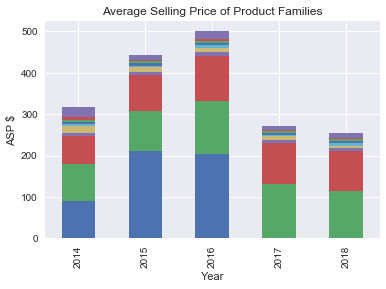

Product Family  1000VDC Solar  Class J 1kV DC Block  Class J SPFJ  \
Year                                                                
2014                    89.45             90.994826     65.806967   
2015                   211.21             95.688235     87.452454   
2016                   205.00            125.894219    108.608939   
2017                     0.00            131.512976     98.115176   
2018                     0.00            113.835486     96.600028   

Product Family  LPHV and LFPHV FHolder  LPXV 1500V Fholders  Midget SPFI  \
Year                                                                       
2014                          8.381004            17.302940     3.488974   
2015                          7.479594            12.943118     2.107967   
2016                          9.771562            11.440943     5.497786   
2017                          8.042416             8.914538     2.303488   
2018                          8.834032             4.726775     6.489434   

Product Family  Midgit KLKD  Midgit SPF  SPXI 1500V In-Line Fuses  \
Year                                                                
2014               6.103347    4.406638                  6.477257   
2015               5.942026    4.583464                  3.960183   
2016               5.541202    4.197840                  5.147766   
2017               5.515991    3.910007                  3.216669   
2018               5.351906    4.012016                  2.801233   

Product Family  SPXV 1500V Fuses  
Year                              
2014                   25.122667  
2015                   12.558577  
2016                   19.010363  
2017                   10.922690  
2018                   12.899069

In [183]:
# Plotting the average selling price of product families over 5 years.

asp_pf=slrprice.groupby(['Year','Product Family'])['ASP-$'].mean().unstack('Product Family').fillna(0)

asp_pf.plot(kind='bar', stacked = True, legend = False)
plt.ylabel('ASP $')
plt.title('Average Selling Price of Product Families')
plt.show()

asp_pf

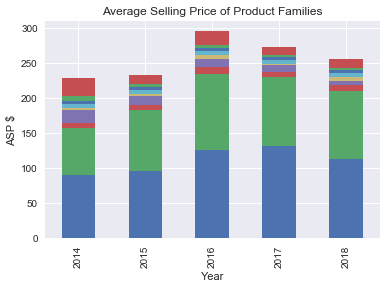

Product Family  Class J 1kV DC Block  Class J SPFJ  LPHV and LFPHV FHolder  \
Year                                                                         
2014                       90.994826     65.806967                8.381004   
2015                       95.688235     87.452454                7.479594   
2016                      125.894219    108.608939                9.771562   
2017                      131.512976     98.115176                8.042416   
2018                      113.835486     96.600028                8.834032   

Product Family  LPXV 1500V Fholders  Midget SPFI  Midgit KLKD  Midgit SPF  \
Year                                                                        
2014                      17.302940     3.488974     6.103347    4.406638   
2015                      12.943118     2.107967     5.942026    4.583464   
2016                      11.440943     5.497786     5.541202    4.197840   
2017                       8.914538     2.303488     5.515991    3.910007   
2018                       4.726775     6.489434     5.351906    4.012016   

Product Family  SPXI 1500V In-Line Fuses  SPXV 1500V Fuses  
Year                                                        
2014                            6.477257         25.122667  
2015                            3.960183         12.558577  
2016                            5.147766         19.010363  
2017                            3.216669         10.922690  
2018                            2.801233         12.899069

In [184]:
asp_yrly_units = asp_pf.loc[:,['Class J 1kV DC Block', 'Class J SPFJ',
                               'LPHV and LFPHV FHolder', 'LPXV 1500V Fholders', 'Midget SPFI',
                               'Midgit KLKD', 'Midgit SPF', 'SPXI 1500V In-Line Fuses','SPXV 1500V Fuses']]

asp_yrly_units.plot(kind='bar', stacked = True, legend = False)
plt.ylabel('ASP $')
plt.title('Average Selling Price of Product Families')
plt.show()

asp_yrly_units

#### 5. Can you make a scatterplot?

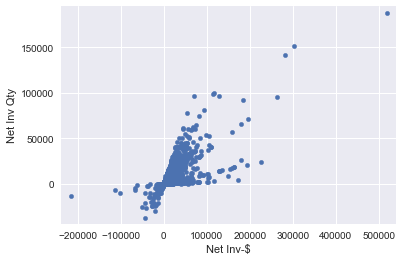

In [104]:
# Scatter Plot of Qty vs Dollars
slrprice.plot(kind='scatter', x='Net Inv-$', y='Net Inv Qty')
plt.margins(0.03)
plt.show()

#### 6. Can you make a time-series plot?
Time plot of Sales Qty vs Dollars over a period of 5 years

In [105]:
ss_totglob = ss_sls.groupby('Date')['Net Inv Qty', 'Net Inv-$'].sum() 

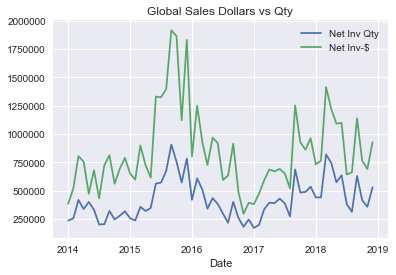

In [106]:

ss_totglob['2014':'2018'].plot(title='Global Sales Dollars vs Qty'); plt.show()



In [156]:
ss_totglob_qty = ss_sls.groupby('Date')['Net Inv Qty'].sum() 
ss_totglob_qty.head()

Date
2014-01-01    234724.0
2014-02-01    253304.0
2014-03-01    416629.0
2014-04-01    335944.0
2014-05-01    398767.0
Name: Net Inv Qty, dtype: float64

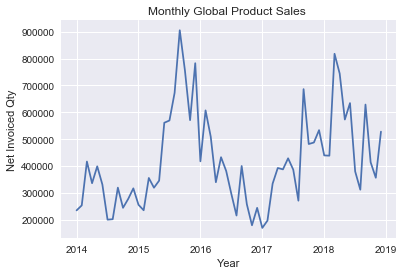

In [174]:
ss_totglob_qty.plot()
plt.title('Monthly Global Product Sales ')
plt.xlabel('Year')
plt.ylabel('Net Invoiced Qty')
plt.show()

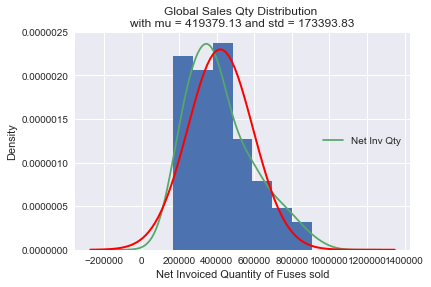

In [182]:
# GRAPHICAL REPRESENTATION OF THE DATA DISTRIBUTION



# Determining bin size
bin_num = int(np.sqrt(len(ss_totglob_qty)))

# Extracting the mean and standard deviation from the temperature distribution:
mu, std = st.norm.fit(ss_totglob_qty)

# Plot the histogram.
plt.hist(ss_totglob_qty, bins=bin_num, density=True)
ss_totglob_qty.plot(kind = 'kde')
# Plot the PDF.
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = st.norm.pdf(x, mu, std)
plt.plot(x, p, 'r', linewidth=2)
plt.title(f"Global Sales Qty Distribution \nwith mu = {mu:.2f} and std = {std:.2f}")
plt.xlabel('Net Invoiced Quantity of Fuses sold')
plt.show()

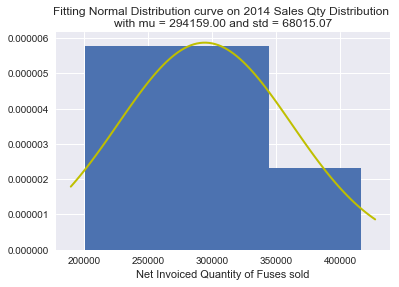

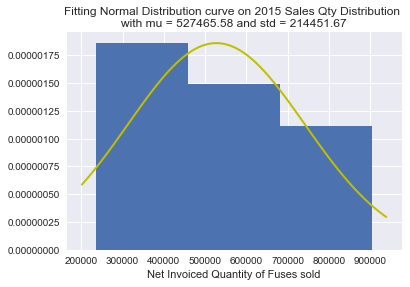

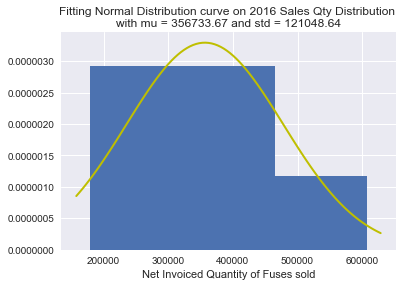

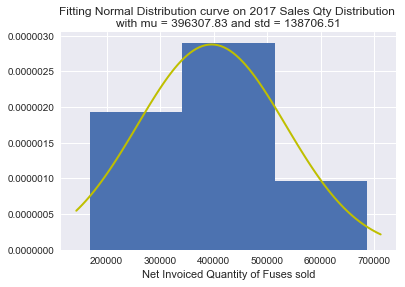

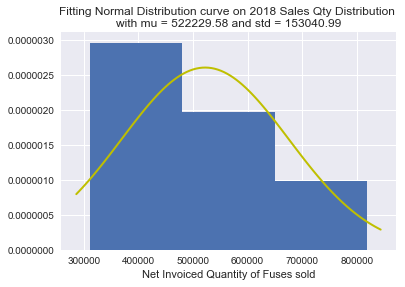

In [168]:
# GRAPHICAL REPRESENTATION OF THE DATA

year = ss_totglob.index.year.unique()

for i in year:
     
    #Determining bin size
    bin_num = int(np.sqrt(len(ss_totglob['Net Inv Qty'][str(i)])))

    # Extracting the mean and standard deviation from the temperature distribution:
    mu, std = st.norm.fit(ss_totglob['Net Inv Qty'][str(i)])

    # Plot the histogram.
    plt.hist(ss_totglob['Net Inv Qty'][str(i)], bins=bin_num, density=True)

    # Plot the PDF.
    xmin, xmax = plt.xlim()
    x = np.linspace(xmin, xmax, 100)
    p = st.norm.pdf(x, mu, std)
    plt.plot(x, p, 'y', linewidth=2)
    plt.title(f'Fitting Normal Distribution curve on {i} Sales Qty Distribution \nwith mu = {mu:.2f} and std = {std:.2f}')
    plt.xlabel('Net Invoiced Quantity of Fuses sold')
    plt.show()

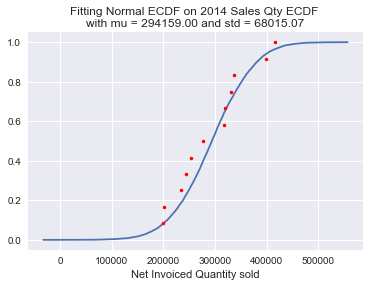

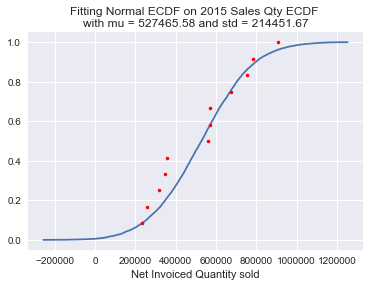

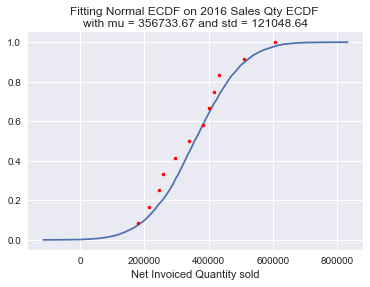

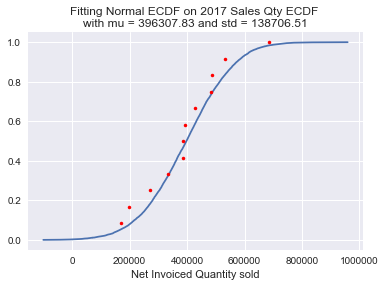

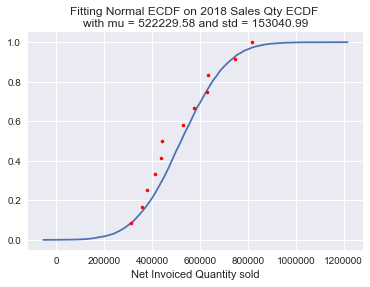

In [176]:
# GRAPHICAL REPRESENTATION OF THE DATA ECDF


def ecdf(data):
    """Compute Empirical Cumulative Distribution Function (ECDF) for a 1D array of measurements."""
    # Number of data points
    n = len(data)
    
    # Data for the x-axis of the ecdf.
    x = np.sort(data)
    
    # Data for the y-axis of the ecdf
    y = np.arange(1, n+1)/n
    
    return x , y

year = ss_totglob.index.year.unique()

for i in year:

    # Extracting the mean and standard deviation from the temperature distribution:
    mu, std = st.norm.fit(ss_totglob['Net Inv Qty'][str(i)])

    # Normal distribution having the same mu and std.
    normal_dist = np.random.normal(mu, std, size=10000)
    
    # ECDF Values
    x, y = ecdf(ss_totglob['Net Inv Qty'][str(i)])
    x_norm, y_norm = ecdf(normal_dist)

    # Plot the ECDF.
    plt.plot(x_norm,y_norm)
    plt.plot(x,y, marker='.', color = 'r', linestyle='none')
  
    plt.title(f'Fitting Normal ECDF on {i} Sales Qty ECDF \nwith mu = {mu:.2f} and std = {std:.2f}')
    plt.xlabel('Net Invoiced Quantity sold')
    plt.show()

In [110]:
ss_totglob_qty.describe()

count        60.000000
mean     419379.133333
std      174857.092662
min      169401.000000
25%      291368.000000
50%      386906.500000
75%      529386.500000
max      905683.000000
Name: Net Inv Qty, dtype: float64

In [111]:
ss_sls.head()

End Customer Product Family Geographic Region  \
Date                                                                      
2014-01-01      SUN-WA TECHNOS(DAIHEN)    Midgit KLKD              ASIA   
2014-01-01                 MEFER, S.L.     Midgit SPF              EMEA   
2014-01-01  SOLAR CITY / VERENGO SOLAR    Midgit KLKD            US/CAN   
2014-01-01                    GRAINGER    Midgit KLKD            US/CAN   
2014-01-01      EMMCO & ASSOCIATES INC   Class J SPFJ            US/CAN   

                       Distributor  Part Number Quarter  Net Inv Qty  \
Date                                                                   
2014-01-01         FUJIX CO., LTD.    KLKD005.T      Q1        200.0   
2014-01-01      FUTURE ELECTRONICS    0SPF030.T      Q1       2600.0   
2014-01-01        FASTENAL COMPANY    KLKD015.T      Q1        340.0   
2014-01-01                GRAINGER  KLKD008.HXG      Q1        100.0   
2014-01-01  EMMCO & ASSOCIATES INC    SPFJ250.X      Q1          1.0   

            Net Inv-$  
Date                   
2014-01-01     558.93  
2014-01-01    3943.37  
2014-01-01    1139.00  
2014-01-01     349.00  
2014-01-01       0.00

In [112]:
ss_totglob_qty = ss_sls.groupby(['Geographic Region', 'Date'])['Net Inv Qty'].sum() 
ss_totglob_qty.ASIA.describe()

count        60.000000
mean     176493.400000
std       92243.297734
min       41050.000000
25%      103555.000000
50%      158588.500000
75%      229163.750000
max      436569.000000
Name: Net Inv Qty, dtype: float64